# Scopo del notebook: 
- ## testare la rete su una sequenza di immagini
- ## produrre un video con i risultati ottenuti

#### Costanti

In [2]:
# percorso dove ho salvato il modello
SAVE_PATH = 'trained/bright_res_v2/bright_res_v2_best.pth'

# fattore di ridimensionamento dell'immagine (prima di essere centrata con dimensione 300)
RESIZE_VALUE = 600

# percorso dove ho salvate le immagini
test_path2 = 'images/stress-test/'
# dove trovo le classi da predire
test_path = 'data/images_scraped/'

### Imports

In [3]:
import torch, torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage, CenterCrop, Normalize, Compose
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip
import matplotlib.pyplot as plt

import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image
from PIL.features import pilinfo

from copy import deepcopy


import traceback
import warnings
warnings.filterwarnings("error")

import cv2
from numpy import asarray
import copy
import os

### Funzioni per recuperare i dati

 - getSingleLabelList(percorso del dataset): ritorna una Series costituita da indice numerico a cui associa l'immagine (nome) ed una finta label (visto che qui non ho un test vero e proprio ma osservo le predizioni fatte)
 - getSingleImgPool(percorso del dataset): ritorna una Series costituita da indice numerico a cui associa il percorso assoluto dell'immagine, la finta label e la finta classe

In [4]:
# for the single class usage, i have only images in the test_path2 and i put manually the label to each
def getSingleLabelList(path):
    ret = {}
    index = 0
    for img in [ name for name in os.listdir(path) ]:
        ret[index] = [img, 0]
        index += 1
    
    return pd.Series(ret)

In [5]:
# create the pool of images from video (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getSingleImgPool(path):
    ret = {}
    index = 0
    for img in [ name for name in os.listdir(path) ]:
        abs_path = path + '/' + img
        ret[index] = [abs_path, 0, 'fake class']
        index += 1
    
    return pd.Series(ret)

## Creazione della struttura dataset (contenitore di immagini)

### ResNet18
Non utilizzo la Lenet visto che il video è registrato in RGB e la Resnet è stata allenata con augmentation apposite che simulino un video (luminosità e traslazione)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
        self.img_labels = getSingleLabelList(path_labels)
        self.images = getSingleImgPool(path_labels)
        self.transform = transform
        self.target_transform = target_transform
        self.use_aug = use_aug

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try: 
            image = Image.open(self.images.loc[idx][0])
            if Image.MIME[image.format] == 'image/png': #formato errato
                    image = convertPNGImage(self.images.loc[idx][0], 'PNG')
        except Exception:
            print('Found error at {} in position {}'.format(self.images.loc[idx][0], idx))

        image = ToTensor()(image)

        if image.shape[0] != 3: #converto le immagini in bianco e nero e RGBA in RGB
            image = ToPILImage()(image).convert('RGB')  
        else: #immagine già RGB
            image = ToPILImage()(image)

        preprocess = Compose([
            Resize(300),
            CenterCrop(300),
            ToTensor(),
        ])
        image = preprocess(image)

        #parte di data augmentation
        if self.use_aug:
            fr = random.choices([0,1],[0.5,0.5])[0] # cambio luminosita (50% probabilità di capitare)
            if fr == 1:
                num = 0.5 + random.random()
                image = adjust_brightness(image, num)

            fr = random.choices([0,1],[0.2,0.8])[0] # rotazione (80% probabilità di capitare)
            if fr == 1: 
                angle = torch.randint(40, size=(1,)).item() - 20
                image = rotate(image, angle)

            fr = random.choices([0,1],[0.5,0.5])[0] # specchiamento asse y (50% probabilità di capitare)
            if fr == 1: 
                image = hflip(image)

            fr = random.choices([0,1],[0.5,0.5])[0] # traslazione (50% probabilità di capitare)
            if fr == 1:
                trX = torch.randint(200, size=(1,)).item() - 100
                trY = torch.randint(200, size=(1,)).item() - 100
                image = affine(image, angle=0, translate=(trX, trY), scale=1, shear=0)

            fr = random.choices([0,1],[0.5,0.5])[0] # rumore gaussiano (50% probabilità di capitare)
            if fr == 1:
                gauss_noise = np.random.normal(0, 0.4, (image.shape[1], image.shape[2]))
                image = image + gauss_noise

        preprocess2 = Compose([ # secondo preprocess dell'immagine per evitare problemi con il cambio luminosità
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image = preprocess2(image)

        label = self.img_labels.loc[idx][1]

        return image, label

### Creazione del dataset

In [7]:
test_data = CustomImageDataset(path_labels=test_path2, transform=ToTensor(), target_transform=ToTensor(), use_aug=False)

print (f'N° immagini nel test dataset: {test_data.__len__()}')

N° immagini nel test dataset: 220


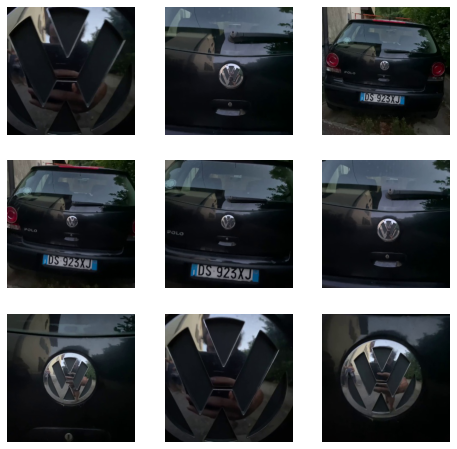

In [8]:
#verifica caricamento delle immagini
only_dirs = [ name for name in os.listdir(test_path) if 
                 os.path.isdir(os.path.join(test_path, name)) ]
diz = {}
nocl=0 # numero di classi
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() 
    img, label = test_data[sample_idx]
    img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

## Creazione dataloader (richiede immagini al dataset, producendo i batch)


In [9]:
test_dl = DataLoader(test_data, batch_size=24, shuffle=True)

Feature batch shape: torch.Size([24, 3, 300, 300])
Labels batch shape: torch.Size([24])


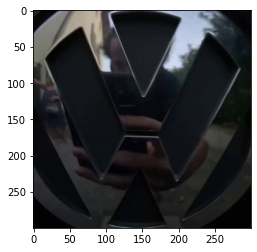

In [10]:
#dataloader test
images, labels = next(iter(test_dl)) #prendo un batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0] # prendo prima immagine dal batch
img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
label = labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()

### Caricamento del modello

In [11]:
loaded = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in C:\Users\eliad/.cache\torch\hub\pytorch_vision_v0.10.0


In [12]:
loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Predizioni di 24 immagini casuali

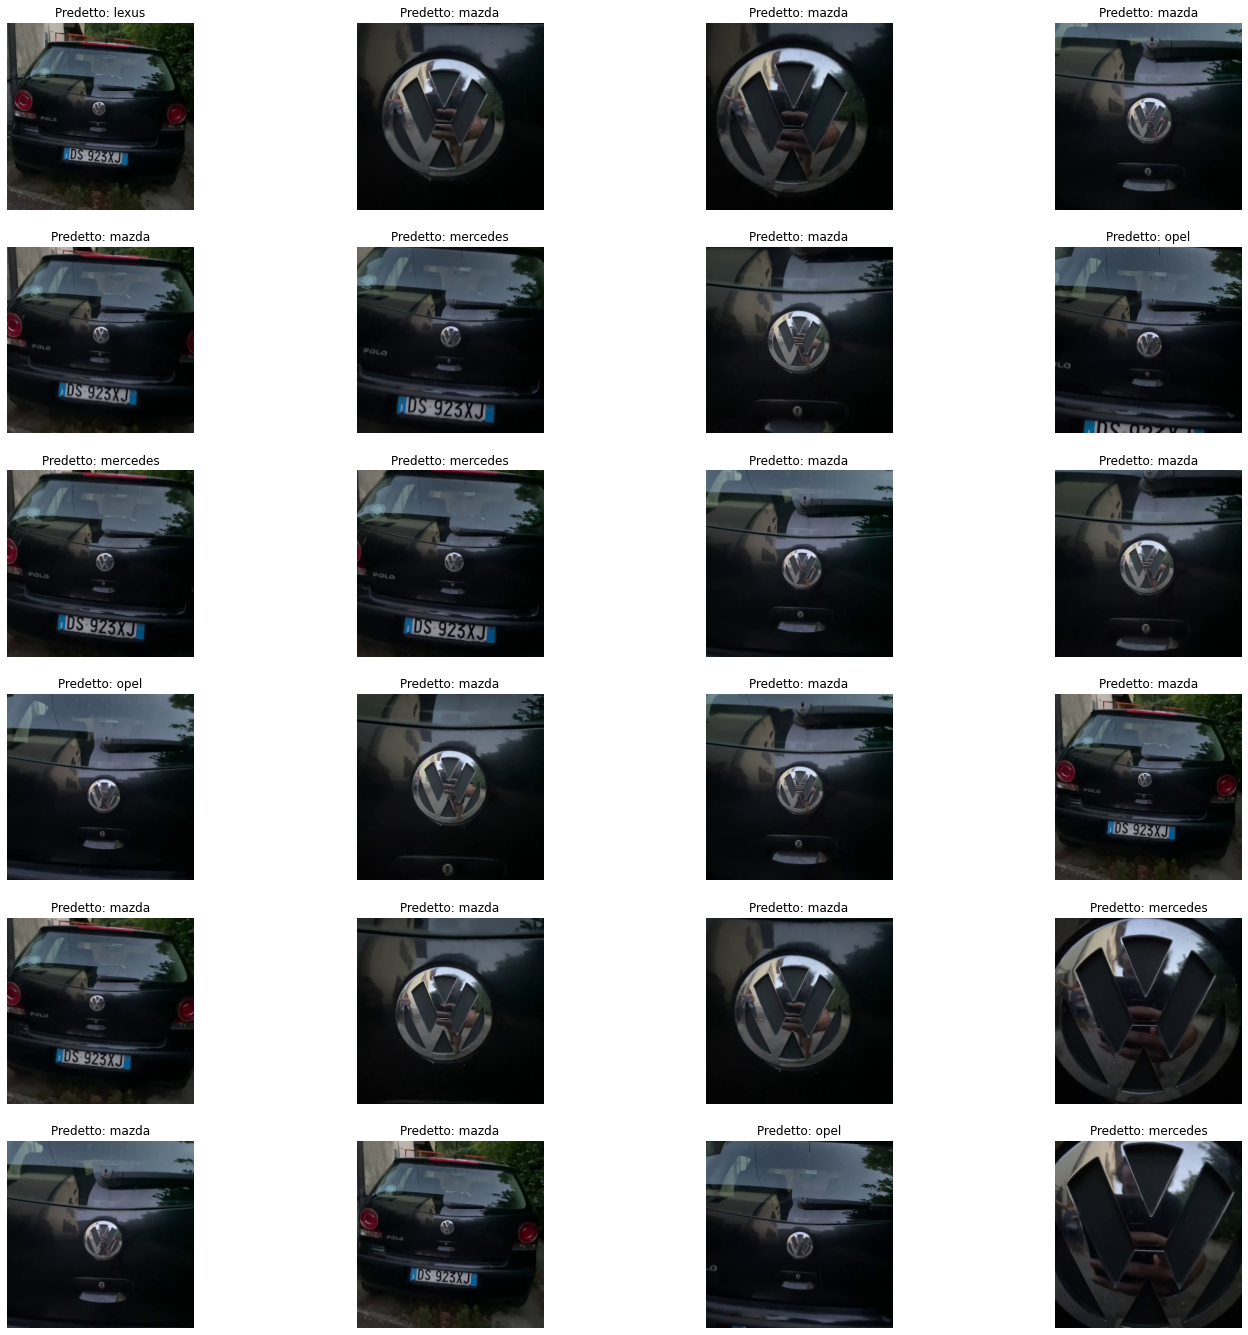

In [13]:
images, labels = next(iter(test_dl)) #picking a batch

n_imgs = len(images)

preds = loaded(images)
_, best_pred = torch.max(preds.data, 1)

figure = plt.figure(figsize=(24, 24))
cols, rows = 4, int(n_imgs/4)
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.title('Predetto: {}'.format(diz[best_pred[i-1].item()]))
    plt.axis("off")
    images[i-1] = images[i-1] * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    plt.imshow(images[i-1].permute(1,2,0)) #use this if rbg
plt.show()

# axs[i].set_title('T: {}\nP: {}'.format(diz[label[i].item()], diz[best_pred[i].item()]))

### Costruzione del video

image processed: 20/220


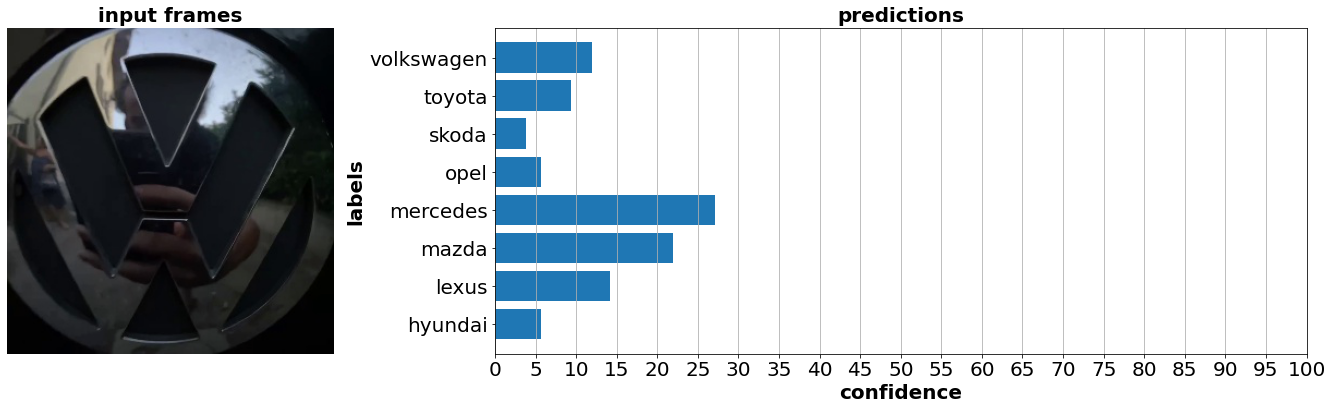

image processed: 40/220


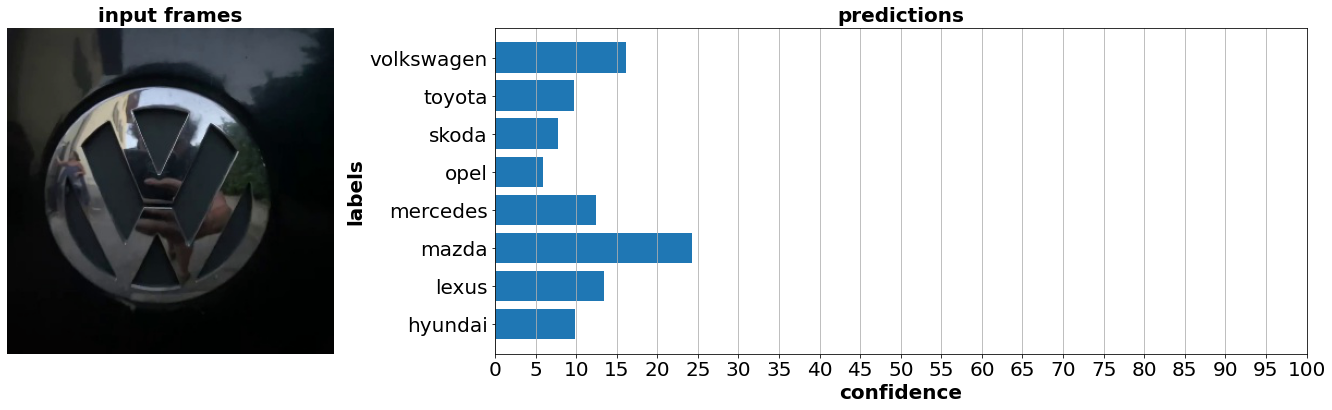

image processed: 60/220


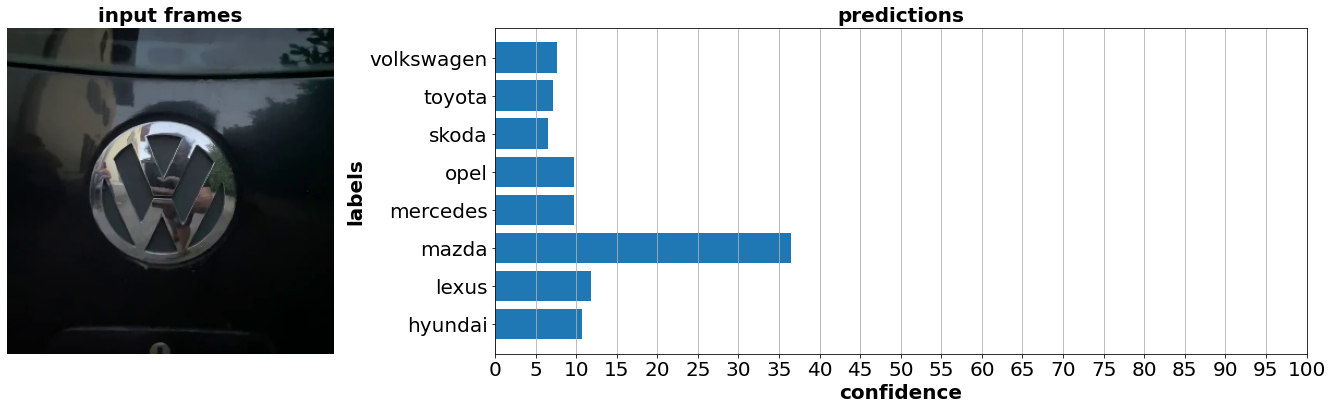

image processed: 80/220


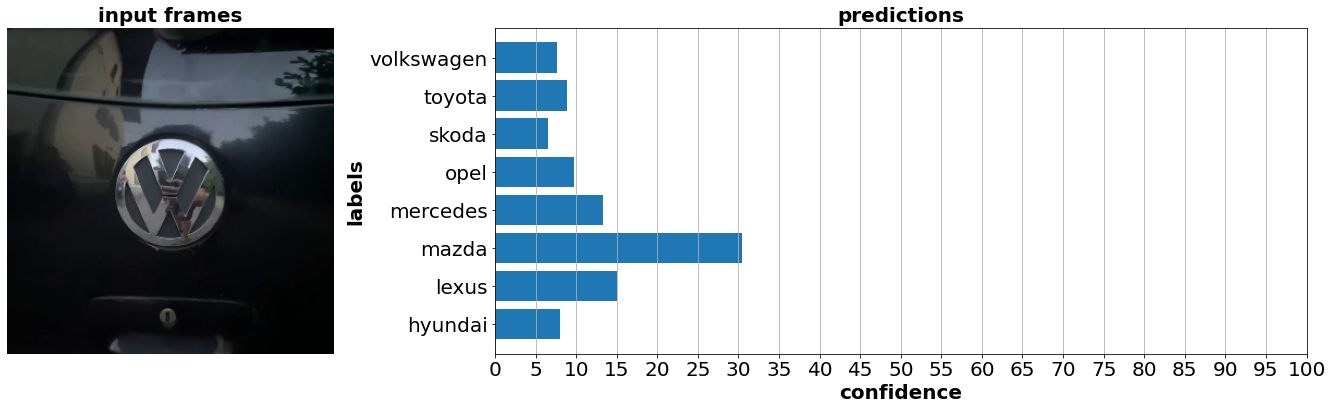

image processed: 100/220


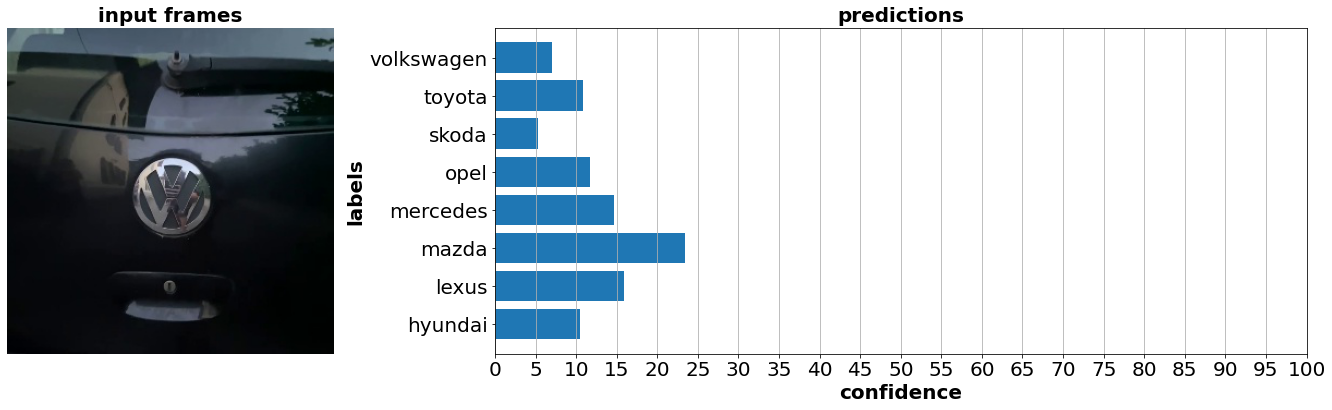

image processed: 120/220


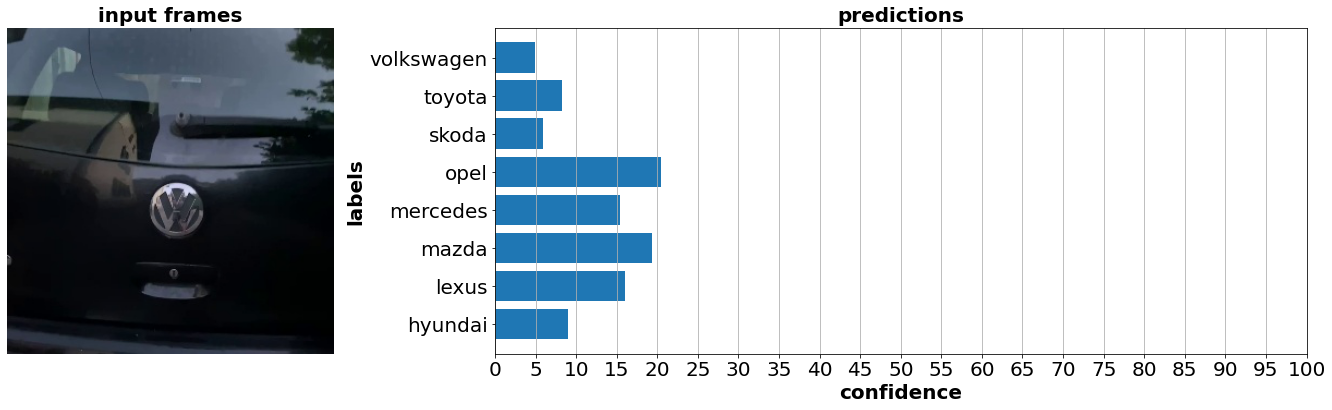

image processed: 140/220


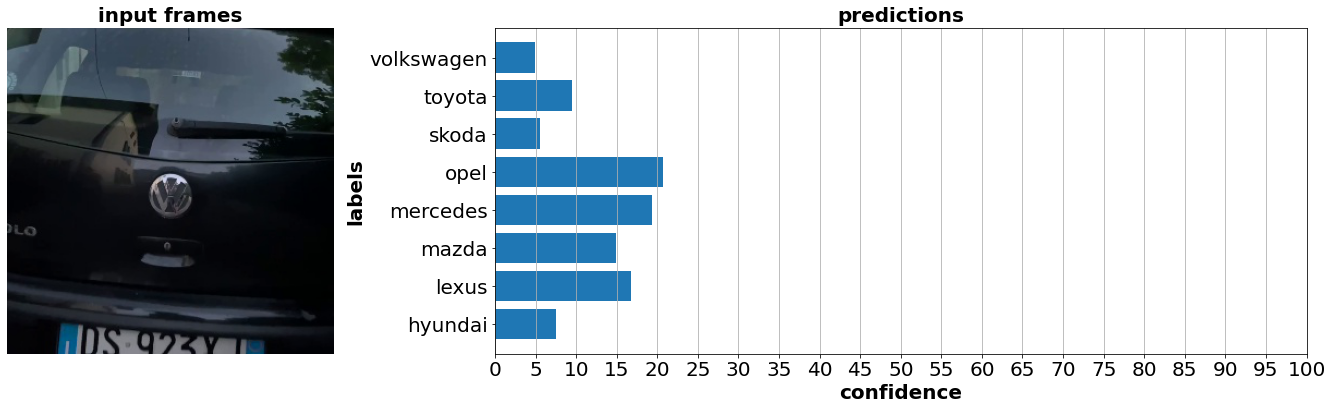

image processed: 160/220


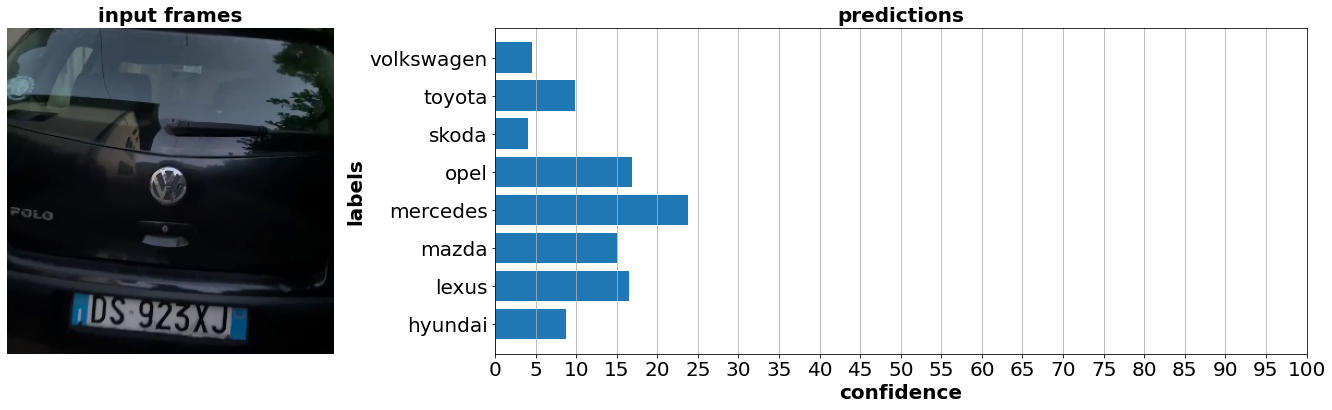

image processed: 180/220


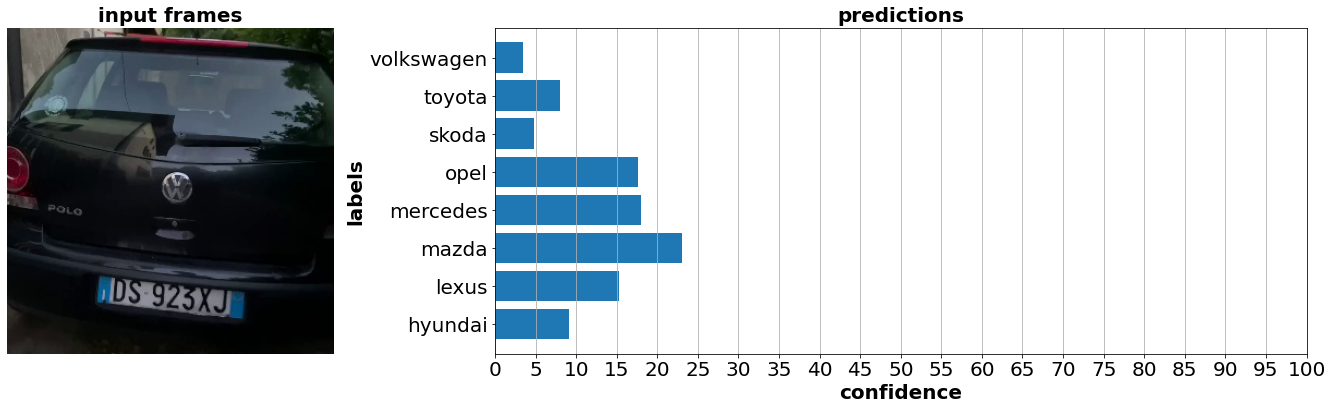

image processed: 200/220


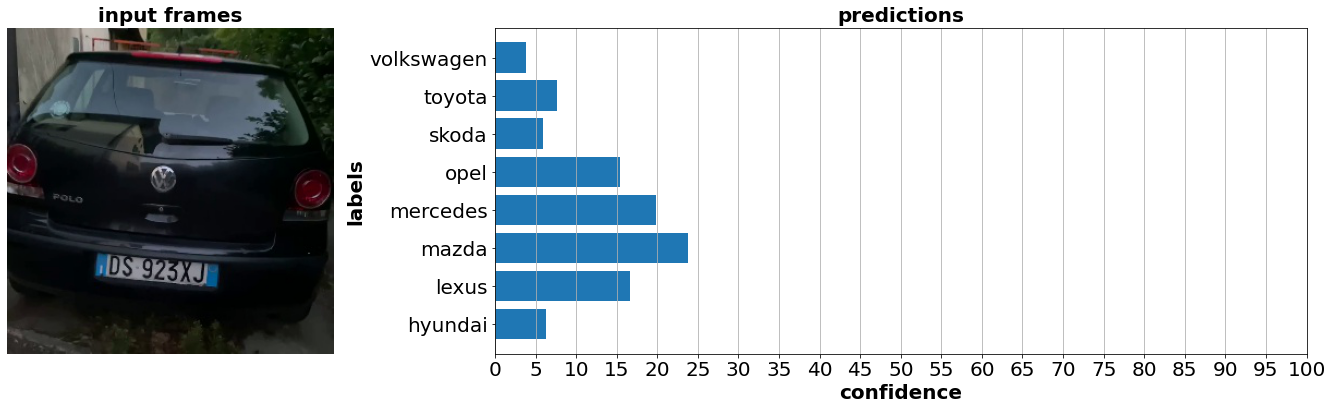

Video salvato al percorso: video/stress-test_bright_res_v2_600.mp4


In [14]:
PLT_SIZE = (24, 6) # necessario per dare la stessa dimensione al plot disegnato e al writer che lo scriverà come video

fig, axs = plt.subplots(figsize=PLT_SIZE, nrows=1, ncols=2)
size = fig.get_size_inches()*fig.dpi # recupero dimensione in pixel
plt.close(fig)

# scelta codifica (qui mp4)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# scelta percorso (qui è costruita come '[nome video]_[nome modello]_RESIZE_VALUE')
VIDEO_PATH = 'video/' + test_path2.split('/')[1] + '_' + SAVE_PATH.split('/')[1] + '_' + str(RESIZE_VALUE) + '.mp4'
# creazione videowriter (costruttore del video)
video = cv2.VideoWriter(VIDEO_PATH, fourcc, 30, (int(size[0]),int(size[1])), isColor=True)

test_dl_single = DataLoader(test_data, batch_size=1, shuffle=False) #batch che contiene l'immagine che analizzo
diz2 = copy.deepcopy(diz) # dizionario che conterrà le predizioni associate alla classe


i = 0
for batch in test_dl_single:
    imgs, label = batch
    out = loaded(imgs)
    _, best_pred = torch.max(out.data, 1)
    perc = torch.nn.functional.softmax(out, dim=1)[0] * 100 # recupero attivazioni e trasformo in percentuali
    _, indices = torch.sort(out, descending=True) # prelevo le classi
    for img in imgs:
        # preprocess immagine per openCV
        img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
        img = img.permute(1,2,0)
        img = img.numpy()
        img = (img*255).astype(np.uint8)
        
        fig, axs = plt.subplots(figsize=PLT_SIZE, nrows=1, ncols=2, gridspec_kw={'width_ratios': [1,2]})
        
        # disegno video
        axs[0].axis('off')
        axs[0].imshow(img)
        axs[0].set_title('input frames', fontsize=20, fontweight='bold')

        #creazione grafico a barre orizzontali
        plt.xlim(0, 100)
        for idx in indices[0][:8]: # assegno ad ogni la classe la sua percentuale
            diz2[idx.item()] = perc[idx].item()
        
        keys = list(diz.keys())
        plt.barh(keys, diz2.values())
        axs[1].xaxis.set_ticks(np.linspace(0,100,21))
        axs[1].set_yticks(keys, labels=list(diz.values()))
        axs[1].grid(axis='x')
        axs[1].tick_params(axis='both', labelsize=20)
        axs[1].set_xlabel('confidence', fontsize=20, fontweight='bold')
        axs[1].set_ylabel('labels', fontsize=20, fontweight='bold')
        axs[1].set_title('predictions', fontsize=20, fontweight='bold')
        
        # salvataggio della figura costruita (video e grafico) in un'immagine
        buffer = io.BytesIO()
        fig.savefig(buffer, format='jpeg')
        buffer.seek(0)
        frame = Image.open(buffer)
        frame = asarray(frame)
        
        # scrittura su video
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        if i % 20 == 0 and i != 0: # durante la scrittura mostro dei frame del video costruito
            print(f"image processed: {i}/{test_data.__len__()}")
            plt.show()
        
        i +=1
        plt.close(fig)

        
# chiusura costruttore (salva il video)
cv2.destroyAllWindows()
video.release()
print('Video salvato al percorso: {}'.format(VIDEO_PATH))